In [1]:
import numpy as np 
import cv2 
import glob 
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
images = glob.glob('test_images/*.jpg')

In [3]:
def threshold(img, sx_thresh = (20,100), s_thresh = (150,255)): 
    # thresholding using S channel from HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]

    # thresholding using R channel from RGB color space 
    red = img[:,:,0]

    # sobel x 
    sobelx = cv2.Sobel(red, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # threshold x gradient 
   
    sx_binary = np.zeros_like(scaled)
    sx_binary[(scaled > sx_thresh[0]) & (scaled <= sx_thresh[1])] = 1

    # thresh S channel
    
    s_binary = np.zeros_like(sat)
    s_binary[(sat > s_thresh[0]) & (sat <= s_thresh[1])] = 1

    # combine binary thresholds 
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (s_binary == 1)] = 1
    
    return combined_binary

In [4]:
def transform_matrix(img_size, offset=75):
    '''
    Calculate perspective transform matrix AND its inverse 
    '''
    # source points: trapezoid surrounding the lane lines
    src = np.float32([[-25, img_size[1]], 
                      [570, 450],
                      [720, 450],
                      [1400, img_size[1]]])
    
    # destination points: entire image w/ offset 
    # TODO: find better destination points
    dst = np.float32([[offset, img_size[1]], 
                      [offset, 0], 
                      [img_size[0]-offset, 0],
                      [img_size[0]-offset, img_size[1]]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    return M, M_inv

In [5]:
def hist(img):
    bottom_half = img[img.shape[0]//2:, :]
    
    # sum image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [16]:
def find_lane_pixels(histogram, img):
    #create output img to draw on + visualize result
    out_img = np.dstack((img,img,img))
    
    # find 2 peaks on the halves of histogram
    midpt = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpt])
    rightx_base = np.argmax(histogram[midpt:]) + midpt
    
    # window HYPERPARAMS
    nwindows = 9
    margin = 100 # width of windows, +/- margin 
    minpix = 50 # min pixels found to recenter window
    
    # window height 
    win_height = np.int(out_img.shape[0]//nwindows)
    
    # x + y positions of nonzero pixels in image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current pos to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # create empty lists for left + right lane pixel indices 
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # id window boundaries in x and y 
        win_y_low = img.shape[0] - (window+1)*win_height
        win_y_high = img.shape[0] - window*win_height
        
        # TODO: Find x boundaries for windows
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw windows 
        cv2.rectangle(out_img, 
                      (win_xleft_low, win_y_low), 
                      (win_xleft_high, win_y_high), (0,255,0), 3)
        
        cv2.rectangle(out_img, 
                      (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0,255,0), 3)
        
        good_left_inds = [i for i in range(len(nonzerox)) \
                          if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high \
                          and nonzerox[i] >= win_xleft_low and nonzerox[i] <= win_xleft_high ]
        good_right_inds = [i for i in range(len(nonzerox)) \
                          if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high \
                          and nonzerox[i] >= win_xright_low and nonzerox[i] <= win_xright_high ]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # TODO: found > minpix pixels, recenter next window 
        if len(good_left_inds) > minpix:
            leftx_current = np.mean([nonzerox[i] for i in good_left_inds]).astype(int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean([nonzerox[i] for i in good_right_inds]).astype(int)
            
    # concat arrays of good indices 
    try:
        left_lane_inds = np.concatenate(left_lane_inds).astype(int)
        right_lane_inds = np.concatenate(right_lane_inds).astype(int)
    except ValueError:
        pass
    
    # extract left and right line pixel positions 
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):    
    # TODO: fit 2nd order poly using np.polyfit
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x + y values for plotting 
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + ploty
        right_fitx = 1*ploty**2 + ploty
 
    return left_fitx, right_fitx, ploty

In [ ]:
def search_around_poly(img, left_fit, right_fit):
    margin = 100 # hyperparameter
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    
    left_lane_inds = []
    right_lane_inds = [] 
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_lane_inds = [i for i in range(len(nonzerox)) \
                      if  nonzerox[i] >= left_fitx[nonzeroy[i]]-margin and 
                      nonzerox[i] <= left_fitx[nonzeroy[i]]+margin ]
    
    right_lane_inds = [i for i in range(len(nonzerox)) \
                      if  nonzerox[i] >= right_fitx[nonzeroy[i]]-margin and 
                      nonzerox[i] <= right_fitx[nonzeroy[i]]+margin ]
        
    # extract left and right line pixel positions 
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    print(len(leftx), len(lefty), len(rightx), len(righty))
    
    return leftx, lefty, rightx, righty

In [39]:
def measure_curvature_real(left_fitx, right_fitx, ploty, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    left_fit = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y to find radius of curvature, max y value corresponding to bottom of image
    y = np.max(ploty)
    
    # calculate R_curve 
    # R_curve = ([1+(2Ay+B)^2]^(3/2)) / |2A|
    left_curverad = (1+(2*left_fit[0]*y*ym_per_pix+left_fit[1])**2)**(3/2) / np.abs(2*left_fit[0]) 
    right_curverad = (1+(2*right_fit[0]*y*ym_per_pix+right_fit[1])**2)**(3/2) / np.abs(2*right_fit[0])
    
    return (left_curverad+right_curverad) / 2

In [28]:
def draw_warped_lane(warped, left_fitx, right_fitx, ploty):
    # create blank image to draw lines
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # recast x+y points to use cv2.fillPoly()
    pts_left = np.array([  np.transpose(  np.vstack([left_fitx, ploty])  ) ])
    pts_right = np.array([ np.flipud( np.transpose(  np.vstack([right_fitx, ploty])  ) ) ])
    pts = np.hstack((pts_left, pts_right))
    
    # draw lane on warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    return color_warp

def draw_warped_lines(color_warp, leftx, lefty, rightx, righty):
    color_warp[lefty,leftx] = [255,0,0]
    color_warp[righty, rightx] = [0,0, 255]
    
    return color_warp

In [43]:
def find_offcenter(histogram, xm_per_pix):
    '''
    Calculates the offset of the vehicle to the center of the lane in meters.
    '''
    # find 2 peaks on the halves of histogram
    midpt = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpt])
    rightx_base = np.argmax(histogram[midpt:]) + midpt
    
    offset_pix = (leftx_base + rightx_base) / 2 - midpt
    
    return offset_pix * xm_per_pix

In [54]:
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )

# Read in the saved camera matrix
mtx = dist_pickle["mtx"]

# Read in the saved distortion coefficients
dist = dist_pickle["dist"]

img = mpimg.imread(images[0])

M, M_inv = transform_matrix(img.shape[1::-1])

# text hyperparams
font      = cv2.FONT_HERSHEY_SIMPLEX
topCenter = (img.shape[1]//2-450,70)
fontScale = 1.5
fontColor = (255,255,255)
lineType  = 2

# pixels to meters constant
ym_per_pix = 30/720
xm_per_pix = 3.7/700

def pipeline(img, mtx, dist):
    # undistort image using camera matrix + dist. coeffs 
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # run color and gradient thresholding on image to find lane lines 
    binary = threshold(undist)*255
    
    # warp the image using OpenCV warpPerspective() to see bird's eye view
    warped = cv2.warpPerspective(binary, M, dsize=binary.shape[::-1], flags=cv2.INTER_LINEAR)
    
    # find two peaks of histogram for the two lane lines
    histogram = hist(warped)
    
    # find left and right line pixels with SLIDING WINDOWS
    leftx, lefty, rightx, righty, _ = find_lane_pixels(histogram, warped)
    
    # fit polynomial to lane pixels
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
    # find radius of the curve of the line 
    curverad = measure_curvature_real(left_fitx, right_fitx, ploty, ym_per_pix, xm_per_pix)
    
    # draw warped lane 
    color_warp = draw_warped_lane(warped, left_fitx, right_fitx, ploty)
    color_warp = draw_warped_lines(color_warp, leftx, lefty, rightx, righty)
    
    # warp back to the original image space 
    inv_warp = cv2.warpPerspective(color_warp, M_inv, dsize=binary.shape[::-1], flags=cv2.INTER_LINEAR)
    
    # combine with orignal image 
    result = cv2.addWeighted(undist, 1, inv_warp, .3, 0)
    
    # add text to show curve radius and offset of vehicle 
    cv2.putText(result,'Radius of the Curvature: {:.2f} m'.format(curverad), 
    topCenter, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    offset = find_offcenter(histogram, xm_per_pix)
    cv2.putText(result,'Vehicle is {:.2f} m left of the lane'.format(offset), 
    tuple(np.add(topCenter, (0, 50))), 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    return result

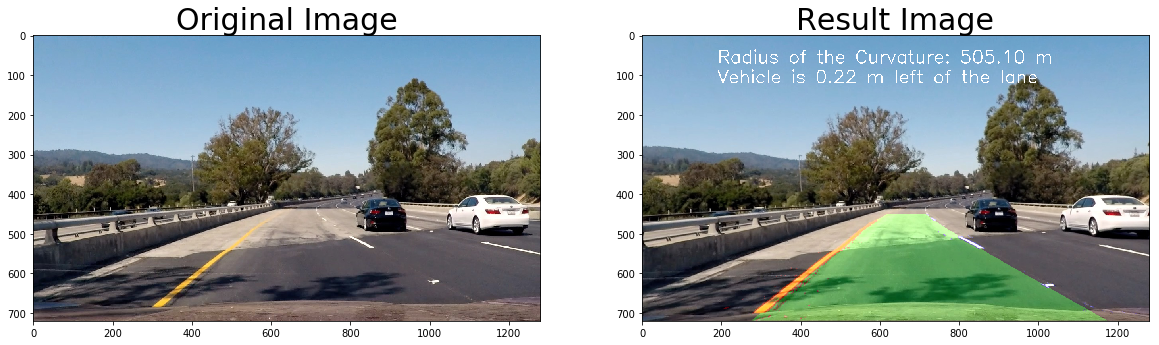

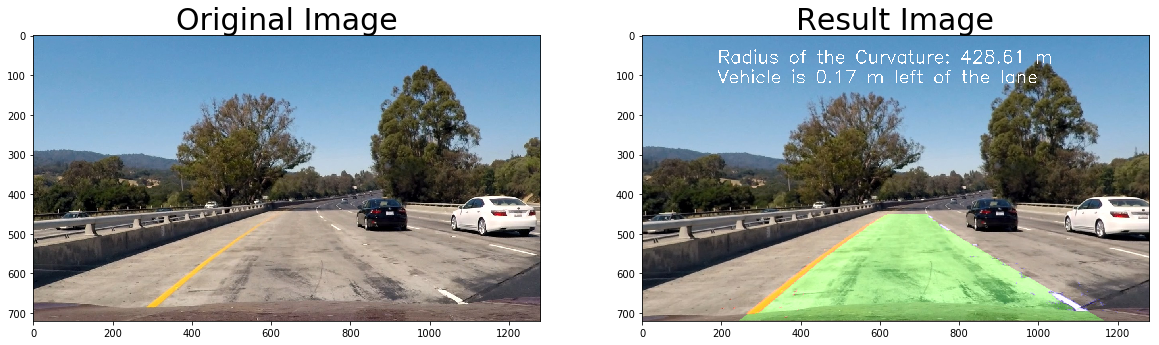

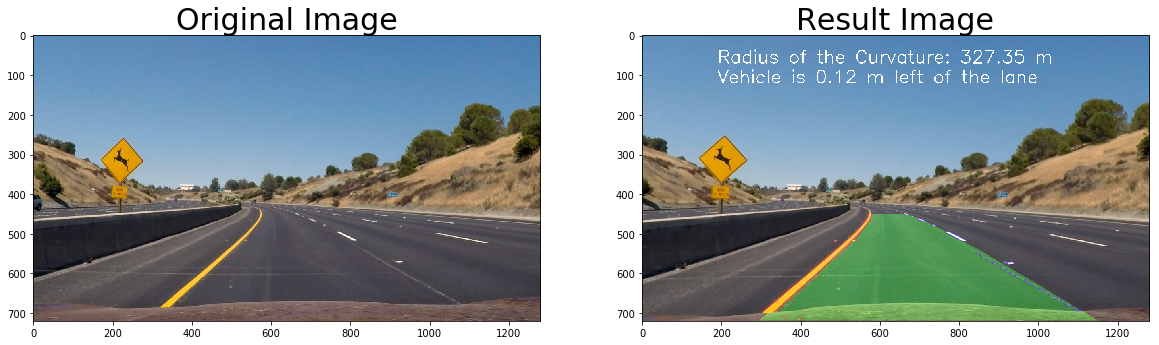

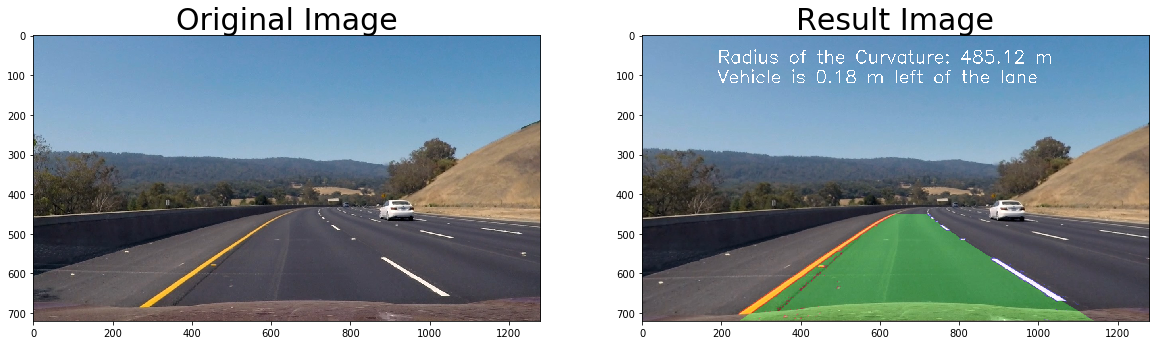

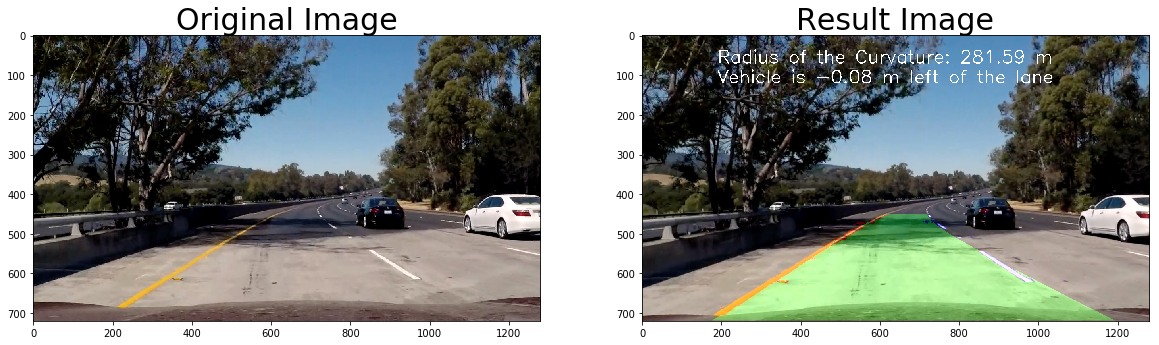

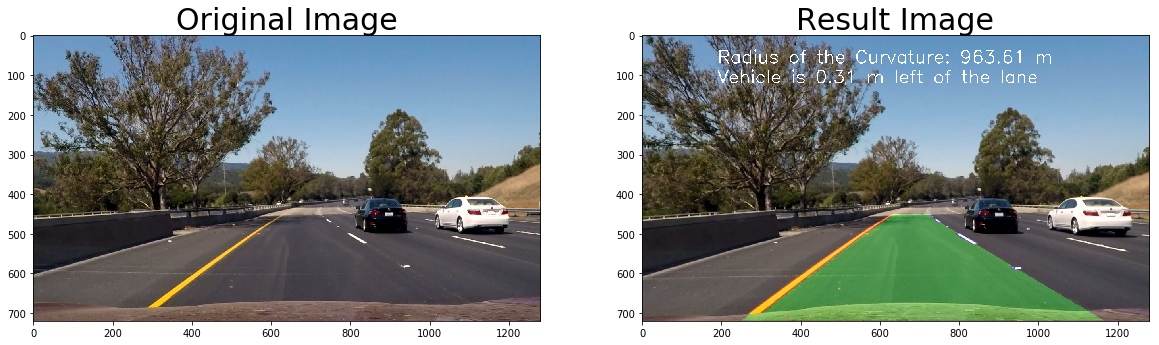

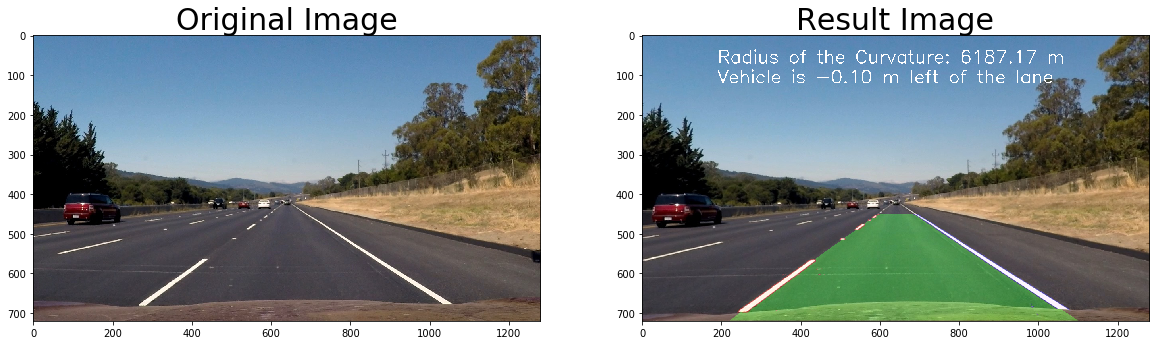

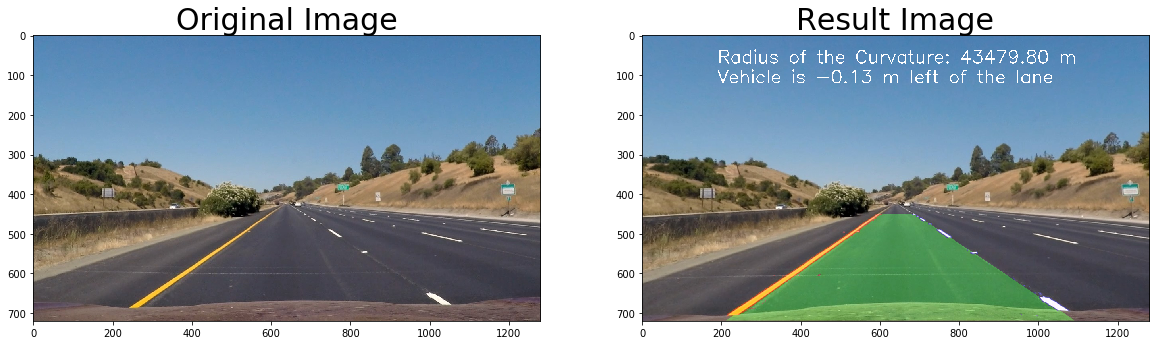

In [55]:
# testing **current** pipeline with images 

for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    dst = pipeline(img, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst, cmap='gray')
    ax2.set_title('Result Image', fontsize=30)